# **CONFIGURAÇÕES INICIAIS**

In [15]:
# @title **Importando Bibliotecas**

# Para manipulação e análise de dados em tabelas (dataframes)
import pandas as pd

# Para cálculos númericos rápidos e eficientes com vetores e matrizes
import numpy as np

# Para criar gráficos e visualizações estáticas
import matplotlib.pyplot as plt

# Para análises de probabilidade
from scipy.stats import chisquare

# Para baixar o CSV via link do Drive
import gdown

In [ ]:
#@title **Importando Amostras de Cada Dataset via Link do Drive**

# Amostra SRAG
srag_file_id = '1E1N10m0YPm0g2PvAnSO5YYc1sFfqrzRi'
srag_url = f'https://drive.google.com/uc?id={srag_file_id}'
srag_output = 'SRAG-2021-RESIZED.csv'
gdown.download(srag_url, srag_output, quiet=False)
df_srag = pd.read_csv(srag_output, sep=',')

# Amostra SIM
sim_file_id = '1P1-TtXlJMgyvVPStpAWHUES55ZqSMoq2'
sim_url = f'https://drive.google.com/uc?id={sim_file_id}'
sim_output = 'SIM-2021-RESIZED.csv'
gdown.download(sim_url, sim_output, quiet=False)
df_sim = pd.read_csv(sim_output, sep=',')

# Impedir importação manual
executar_celula = False

### **Importando o CSV Manualmente (caso o método anterior não funcione)**

Caso o método anterior não funcione, realize o upload manual do CSV:

*   Baixe o arquivo do [SIM](https://drive.usercontent.google.com/uc?id=1P1-TtXlJMgyvVPStpAWHUES55ZqSMoq2&export=download) e do [SRAG](https://drive.usercontent.google.com/uc?id=1E1N10m0YPm0g2PvAnSO5YYc1sFfqrzRi&export=download).
*   Crie uma pasta "Colab Notebooks" no Drive e faça o upload dos CSVs nela.

In [ ]:
#@title { vertical-output: true, form-width: "40%" }
from google.colab import drive

if not executar_celula:
  print("Esta célula não foi executada pois a célula anterior já baixou o CSV.")
else:
  drive.mount('/content/drive/', force_remount=True)
  df_srag = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SRAG-2021-RESIZED.csv', sep=',')
  df_sim = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SIM-2021-RESIZED.csv', sep=',')

## **Preparação dos Dados**


In [85]:
# Filtrando somente as colunas necessárias
sim = df_sim[['CAUSABAS']].copy()
srag = df_srag[['CLASSI_FIN', 'EVOLUCAO']].copy()

# Mapeando as colunas do SRAG
srag['CLASSI_FIN_DESC'] = srag['CLASSI_FIN'].map({
    1: 'Por influenza',
    2: 'Por outro vírus',
    3: 'Por outro agente',
    4: 'Não especificado',
    5: 'Por covid-19'
})

srag['EVOLUCAO_DESC'] = srag['EVOLUCAO'].map({
    1: 'Cura',
    2: 'Óbito',
    3: 'Óbito por outras causas',
    9: 'Ignorado'
})

In [86]:
# @title { vertical-output: true, form-width: "50%" }

# Visualizando o head do SIM
sim.head()

,CAUSABAS
0,I10
1,B342
2,I500
3,I64
4,B342


In [87]:
# @title { vertical-output: true, form-width: "50%" }

# Visualizando o head do SRAG
srag.head()

,CLASSI_FIN,EVOLUCAO,CLASSI_FIN_DESC,EVOLUCAO_DESC
0,5.0,NaN,Por covid-19,NaN
1,4.0,2.0,Não especificado,Óbito
2,5.0,9.0,Por covid-19,Ignorado
3,5.0,1.0,Por covid-19,Cura
4,5.0,1.0,Por covid-19,Cura


---
# **ANÁLISE INFERENCIAL**

**Objetivo:** realizar testes de hipótese para comparar a letalidade aparente no SRAG e a taxa de mortalidade no SIM (considerando as amostras extraídas) para o ano de 2021.

**Teste a ser realizado:** teste de proporção usando qui-quadrado.

**Hipóteses definidas:**
* **Hipótese Nula (H₀):** a taxa de mortalidade registrada no SIM é proporcional à letalidade observada no SRAG.
* **Hipótese Alternativa (Ha):** há uma diferença significativa (subnotificação ou excesso em alguns dos *datasets*.

**Considerar:**
* **Nível de significância (α):** 0.05

In [88]:
# DADOS GERAIS

# Tamanho amostral dos datasets
n_srag = len(srag)
n_sim = len(sim)

# Nível de significância (α)
alpha = 0.05

## **Calculando as Proporções**

In [89]:
# PROPORÇÕES DA ANÁLISE

# SIM
# Filtrando óbitos por COVID-19
filtro_sim_covid = sim['CAUSABAS'].astype(str).str.match('B342')

# Calculando proporções de óbito por COVID-19
p_sim_obito_covid = filtro_sim_covid.mean()
p_sim_obito_nao_covid = 1 - p_sim_obito_covid

# Proporções esperadas
expected_proportions = np.array([p_sim_obito_covid.round(2), p_sim_obito_nao_covid.round(2)])
expected = n_srag * expected_proportions   # Utilizou-se como n o tamanho amostral do SRAG
print(expected)

# SRAG
# Filtrando óbitos por COVID-19
filtro_srag_covid = ((srag['CLASSI_FIN_DESC'] == 'Por covid-19') & (srag['EVOLUCAO_DESC'] == 'Óbito'))
srag_covid = srag[filtro_srag_covid]

# Proporções observadas
n_srag_covid = len(srag_covid)
observed = np.array([n_srag_covid, n_sim - n_srag_covid])

# Exibindo resultados
print(f"Proporções esperadas (SIM): {expected_proportions[0]} → {expected_proportions[0]:.2%} (óbitos por COVID-19) e {expected_proportions[1]} → {expected_proportions[1]:.2%} (não óbitos por COVID-19)")
print(f"Proporções observadas (SRAG): {observed[0]} (óbitos por COVID-19) e {observed[1]} (óbitos não COVID-19)")

[23000. 77000.]
Proporções esperadas (SIM): 0.23 → 23.00% (óbitos por COVID-19) e 0.77 → 77.00% (não óbitos por COVID-19)
Proporções observadas (SRAG): 21707 (óbitos por COVID-19) e 78293 (óbitos não COVID-19)


## **Gerando o Gráfico**

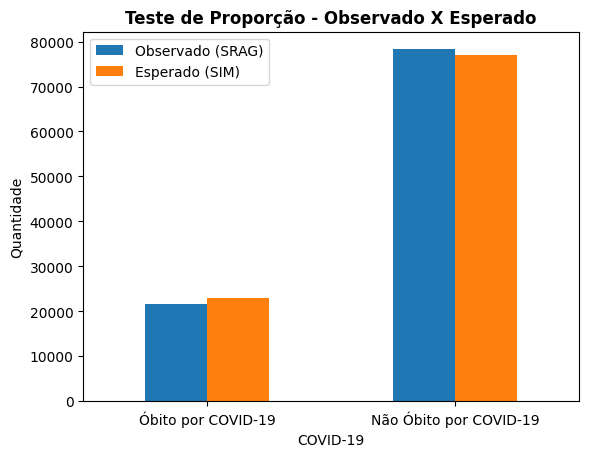

In [94]:
# Criando novo dataframe
analise = pd.DataFrame({
    "Resposta": ['Óbito por COVID-19', 'Não Óbito por COVID-19'],
    "Observado": observed,
    "Esperado": expected
})

# Gráfico
analise.plot(x="Resposta", kind="bar", stacked=False)
plt.title("Teste de Proporção - Observado X Esperado", weight='bold')
plt.xlabel("COVID-19")
plt.ylabel("Quantidade")
plt.xticks(rotation=0)
plt.legend(["Observado (SRAG)", "Esperado (SIM)"])
plt.show()

## **Realizando o Teste Qui-Quadrado**

In [92]:
# Teste de Qui-Quadrado
chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)

# Resultados
# Mede a diferença entre observado e esperado
print(f"Diferença entre os valores observados e esperados: {chi2_stat:.4f}")

# Representa a probabilidade de observar uma diferença ou algo mais extremo, assumindo que H₀ é verdadeira
print(f"Valor do p-value: {p_value:.9f} ({p_value:.7%})")

Diferença entre os valores observados e esperados: 94.4014
Valor do p-value: 0.000000000 (0.0000000%)
